# Symbolic Aggregate approXimation *(SAX)* Encoding
## Distance Matrix DEMO

In [1]:
# at first time install pynuTS with this command
#!pip install git+https://github.com/nickprock/pynuTS.git@main

In [2]:
import pandas as pd
import numpy as np
from pynuTS.decomposition import NaiveSAX

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

Symbolic Aggregate approXimation Encoding (SAX Encoding)

* Developed in 2002 by Keogh e Lin
* Dimensionality Reduction for sequences

* In this example we will use it to find anomaly patterns. For more informations read this [KDNuggets article](https://www.kdnuggets.com/2019/09/time-series-baseball.html).

## Create dataset.

We Create 10 sequences with 12 observations.


In [4]:
# Some useful functions
def sigmoid(x, a, b, c):
    expo = a * (b - x)
    sig = 1 / ( 1 + np.exp( expo ) ) * c
    return sig


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [5]:
time = np.arange(120)

np.random.seed(42)
a = np.random.randn(10)
b = np.random.beta(a[0], a[-1], 10)
c = np.random.normal(loc = 10, scale=0.5,size=10)

list_series = []
for i in range(10):
  noise = white_noise(time)
  temp = sigmoid(time, a[i], b[i], c[i]) + noise
  list_series.append(temp)

### Create DataFrame

* every row is a period
* every column is a sequence

In [6]:
X = pd.DataFrame(list_series).T

In [7]:
X

,0,1,2,3,4,5,6,7,8,9
0,1.349419,3.460584,4.356100,2.072850,5.585070,5.357913,4.012010,2.181351,3.051455,4.181099
1,4.787798,3.634679,5.208038,5.358033,5.048481,2.466006,10.764655,4.458155,4.982820,5.475449
2,6.526755,5.893332,7.930437,8.443402,3.826427,3.729450,9.566010,6.893981,5.320448,6.083505
3,7.329584,4.968624,7.354724,10.600326,4.170043,1.990416,10.290499,6.637959,1.945055,9.707639
4,8.501116,4.252447,10.085835,11.099512,3.026840,2.558609,10.568107,9.329019,1.409858,7.934778
...,...,...,...,...,...,...,...,...,...,...
115,8.029119,0.783293,9.123900,12.876763,1.004399,1.702113,11.195459,11.254160,0.452129,8.845060
116,10.782684,-1.489183,9.101222,10.729358,-0.304155,-0.809437,10.333960,8.861606,0.306933,9.805137
117,9.693469,-0.053873,10.190029,11.700143,-0.378895,1.732265,12.283255,10.921368,0.482172,9.852196
118,10.571295,0.505008,10.203172,10.195607,-0.921803,-1.830864,9.339864,7.992586,0.191212,9.183342


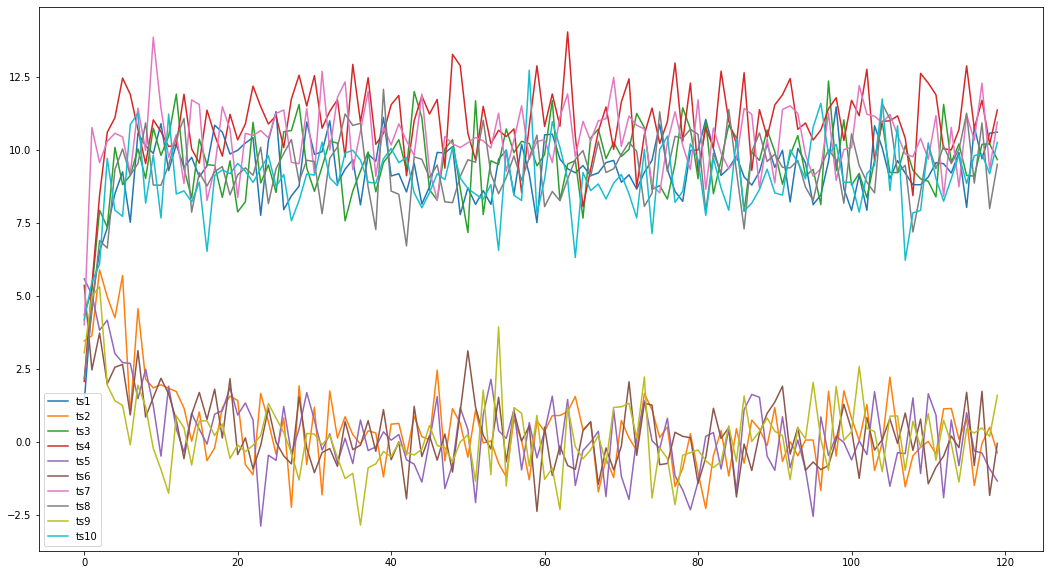

In [8]:
X.plot(figsize=(18,10))
plt.legend(["ts1", "ts2","ts3","ts4","ts5","ts6","ts7","ts8","ts9","ts10"])
plt.show()

## Distance Matrix with SAX Encoding

We choose a window size 12. We reduct the 120 periods in 10 periods, a letter is a year.
You transpose X because each row must be a time series and each column a timestep.

In [9]:
sax = NaiveSAX(windows=12)

In [10]:
sax_strings = np.apply_along_axis(sax.fit_transform, 1, X.T)

## Dimensionality Reduction with **Piecewise Aggregate Approximation**

The **Piecewise Aggregate Approximation** consisting in taking the mean over back-to-back points. This decreases the number of points and reduces noise while preserving the trend of the time series.
The labels for each level form the **SAX String** (like *'AAA'*)

<br>

![PAA](https://www.researchgate.net/profile/Bill-Chiu-2/publication/221653289/figure/fig7/AS:668838362349575@1536474900462/Symbolic-aggregate-approximation-of-a-time-series-as-the-four-letter-word-dbad-The.ppm)

<br>

In [11]:
sax_strings

array(['ACCAABCBBB', 'CCBBABAACB', 'AAACBCCBBB', 'AACBBBABCC',
       'CCBBCAAABB', 'CCABCABBBA', 'AACBBCABCB', 'ABCABACBCB',
       'CBAABBACCB', 'AACBBABBCC'], dtype='<U10')

In [12]:
# We reshape beacuse pdist wants a 2D array
sax1 = sax_strings.reshape(-1,1)

### Choose the distance: Levenshtein
The [***Levenshtein distance***](https://pypi.org/project/python-Levenshtein/) is a text similarity measure that compares two words and returns a numeric value representing the distance between them. The distance reflects the total number of single-character edits required to transform one word into another. The more similar the two words are the less distance between them, and vice versa. One common use for this distance is in the autocompletion or autocorrection features of text processors or chat applications.

<br>

![lev](https://www.statology.org/wp-content/uploads/2020/12/levenshtein1-300x288.png)

<br>

**The Levenshtein distance between the two words (i.e. the number of edits we have to make to turn one word into the other) would be 2.**

In [13]:
# at first time install Levenshtein with this command
#!pip install Levenshtein

In [14]:
from scipy.spatial.distance import pdist, squareform
from Levenshtein import distance as lev

In [15]:
distance_matrix=np.tril(squareform(pdist(sax1, lambda x,y: lev(x[0],y[0])), checks=True), k=-1)

In [16]:
distance_matrix[distance_matrix==0]=np.nan
print(distance_matrix)

[[nan nan nan nan nan nan nan nan nan nan]
 [ 6. nan nan nan nan nan nan nan nan nan]
 [ 4.  8. nan nan nan nan nan nan nan nan]
 [ 6.  5.  6. nan nan nan nan nan nan nan]
 [ 6.  3.  7.  7. nan nan nan nan nan nan]
 [ 4.  6.  5.  7.  4. nan nan nan nan nan]
 [ 5.  5.  4.  2.  5.  5. nan nan nan nan]
 [ 4.  5.  5.  5.  6.  6.  4. nan nan nan]
 [ 6.  4.  6.  6.  7.  6.  5.  4. nan nan]
 [ 6.  5.  5.  2.  7.  6.  3.  4.  5. nan]]


In [17]:
# find similar Time series
index_min = np.where(distance_matrix==np.nanmin(distance_matrix))

In [18]:
minL = []
for i in range(len(index_min)):
    minL.append(index_min[i].tolist())
minL = np.unique(np.reshape(minL, (-1)))

In [19]:
minL

array([3, 6, 9])

In [20]:
for i in minL:
    print(sax_strings[i])

AACBBBABCC
AACBBCABCB
AACBBABBCC


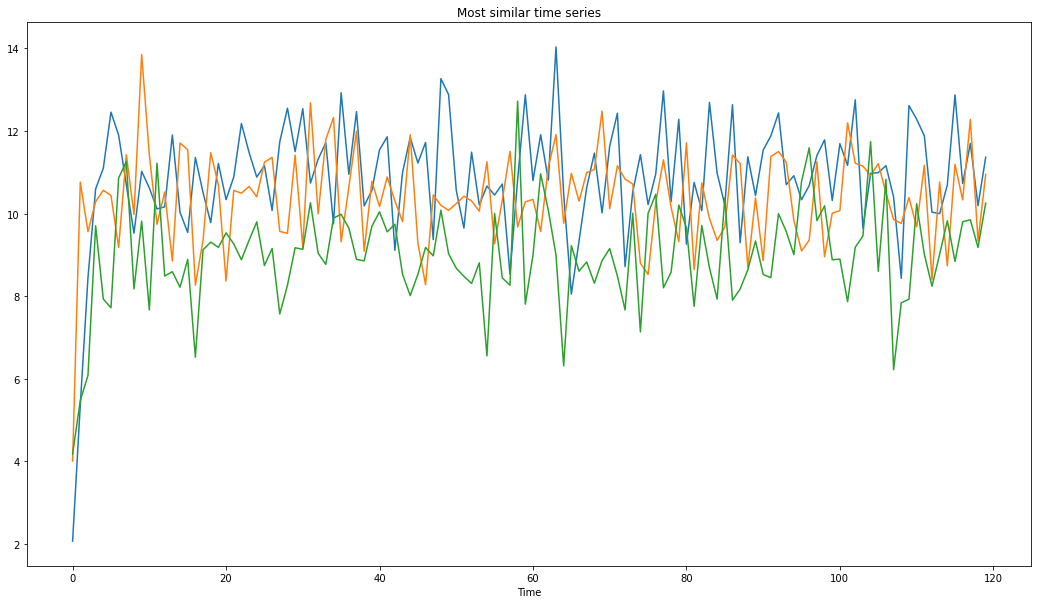

In [21]:
plt.figure(figsize=(18,10))
for i in minL:
    plt.plot(time, X.iloc[:,i].values)
plt.title("Most similar time series")
plt.xlabel("Time")
plt.show()

In [22]:
# find different Time series
# for the moment I don't take couples
index_max = np.where(distance_matrix==np.nanmax(distance_matrix))

In [23]:
maxL = []
for i in range(len(index_max)):
    maxL.append(index_max[i].tolist())
maxL = np.unique(np.reshape(maxL, (-1)))

In [24]:
for i in maxL:
    print(sax_strings[i])

CCBBABAACB
AAACBCCBBB


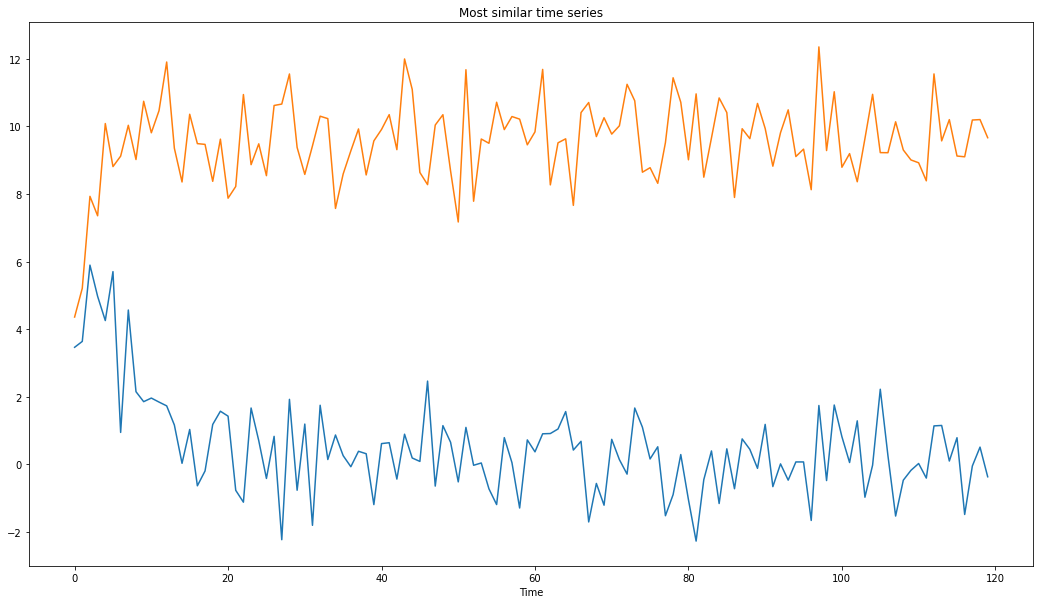

In [25]:
plt.figure(figsize=(18,10))
for i in maxL:
    plt.plot(time, X.iloc[:,i].values)
plt.title("Most similar time series")
plt.xlabel("Time")
plt.show()

## Credits

pynuTS by Nicola Procopio 2020

Original repository https://github.com/nickprock/pynuTS/

<br>

* *The **sigmoid** function was created by [Piero Savastano](https://github.com/pieroit) for [covid19italia](https://github.com/ondata/covid19italia/blob/master/visualizzazione/analisi_predittiva.ipynb)*

* *The **white_noise** function was created by [Aurélien Géron](https://github.com/ageron) for an Udacity course*
